In [73]:
import librosa
import numpy as np
import os
import matplotlib.pyplot as plt
from pydub import AudioSegment

rel_path_to_audio = r"..\data\0_raw\prince.mp3"

path_to_audio = os.path.normpath(os.path.join(os.getcwd(), rel_path_to_audio))

format = os.path.splitext(path_to_audio)[-1].lower().lstrip(".")
print(f"{format=}")
audio = AudioSegment.from_file(path_to_audio, format=format)

# Pobierz dane audio jako tablicę NumPy
data = np.array(audio.get_array_of_samples())

# Pobierz częstotliwość próbkowania
sr = audio.frame_rate
data, sr = librosa.load(path_to_audio)

format='mp3'


In [74]:
def add_echo_to_audio(data, alpha, delta, generate_keys=False, seed=None):
    """Dodaje echo do sygnału audio.

    Kopiuje sygnał i dodaje echo do każdego kanału (mono lub stereo) według formuły: x[n] + alpha * x[n - delta].
    Obsługuje sygnały mono i stereo. Nie normalizuje sygnału.

    Args:
        data (numpy.ndarray): Sygnał audio, tablica 1D (mono) lub 2D (stereo, shape: [próbki, kanały]).
        alpha (float): Siła echa (np. 0.4 dla umiarkowanego echa).
        delta (int): Opóźnienie echa w próbkach (np. 100 dla ~2.3 ms przy 44.1 kHz).

    Returns:
        numpy.ndarray: Sygnał z dodanym echem, ten sam kształt co wejściowy.

    Raises:
        ValueError: Gdy data jest pusta lub delta jest ujemne/zero.
        TypeError: Gdy data nie jest tablicą numpy.ndarray.

    Example:
        >>> import numpy as np
        >>> signal = np.zeros(1000)  # Mono, 1000 próbek
        >>> signal[0] = 1.0
        >>> echoed = add_echo_to_audio(signal, alpha=0.4, delta=100)
        >>> print(echoed[100])  # Powinno być 0.4
    """
    keys = []
    if generate_keys == True:
        if seed is None:
            seed = np.random.randint(0, 1000000)  # Losowy seed
        np.random.seed(seed)
        for _ in range(len(data)):
            keys.append(np.random.randint(2))
        print(np.array(keys))
    
    # Sygnał wejściowy
    output = np.copy(data)

    if len(data.shape) > 1:
        # Dodaj echo do każdego kanału: x[n] + alpha * x[n - delta]
        for channel in range(data.shape[1]):  # Iteruj po kanałach (0: lewy, 1: prawy)
            for i in range(delta, len(data)):
                if generate_keys == True:
                    output[i, channel] += alpha * data[i - delta, channel] * keys[i]
                else:
                    output[i, channel] += alpha * data[i - delta, channel]
                    
    else:
        # Dodaj echo do kanału
        for i in range(delta, len(data)):
                output[i] += alpha * data[i - delta]
            
    return output

In [75]:
def add_echo_to_file(input_file, output_file, alpha, delta, generate_keys=False, seed=None):
    """Dodaje echo do pliku audio.

    Wczytuje plik audio, dodaje echo do każdego kanału sygnału i zapisuje wynik w rozszerzeniu pliku wyjściowego.
    Echo jest dodawane jako: x[n] + alpha * x[n - delta]. Sygnał jest normalizowany,
    aby uniknąć przesterowania.

    Args:
        input_file (str): Ścieżka do wejściowego pliku audio (mono lub stereo).
        output_file (str): Ścieżka do pliku wyjściowego WAV.
        alpha (float): Siła echa (np. 0.4 dla umiarkowanego echa).
        delta (int): Opóźnienie echa w próbkach (np. 100 dla ~2.3 ms przy 44.1 kHz).

    Returns:
        None: Funkcja zapisuje plik WAV z echem.

    Raises:
        FileNotFoundError: Gdy plik wejściowy nie istnieje.
        RuntimeError: Gdy zapis pliku wyjściowego nie powiedzie się.

    Example:
        >>> add_echo("input.wav", "output.wav", alpha=0.4, delta=100)
        # Dodaje echo o sile 0.4 z opóźnieniem 100 próbek do input.wav
        # Zapisuje wynik w output.wav
    """
    
    # Wczytaj plik audio
    data, sr = librosa.load(input_file)

    # Dodaj echo do sygnału
    output = add_echo_to_audio(data=data, alpha=alpha, delta=delta, generate_keys=generate_keys, seed=seed)

    # Normalizuj sygnał, aby uniknąć przesterowania
    output = np.clip(output, -32768, 32767)  # Dla 16-bitowego WAV

    # Zapisz plik wyjściowy
    format = os.path.splitext(output_file)[-1].lower().lstrip(".")
    output.export(output_file, format=format)

In [76]:
alpha = 0.4
output_with_echo = data
deltas = [50, 75, 100]
for delta in deltas:
    output_with_echo = add_echo_to_audio(output_with_echo, alpha, delta, generate_keys=True, seed=9722)

[0 1 0 ... 1 1 1]
[0 1 0 ... 1 1 1]
[0 1 0 ... 1 1 1]


In [77]:
#sd.play(output, sr)
#sd.wait()

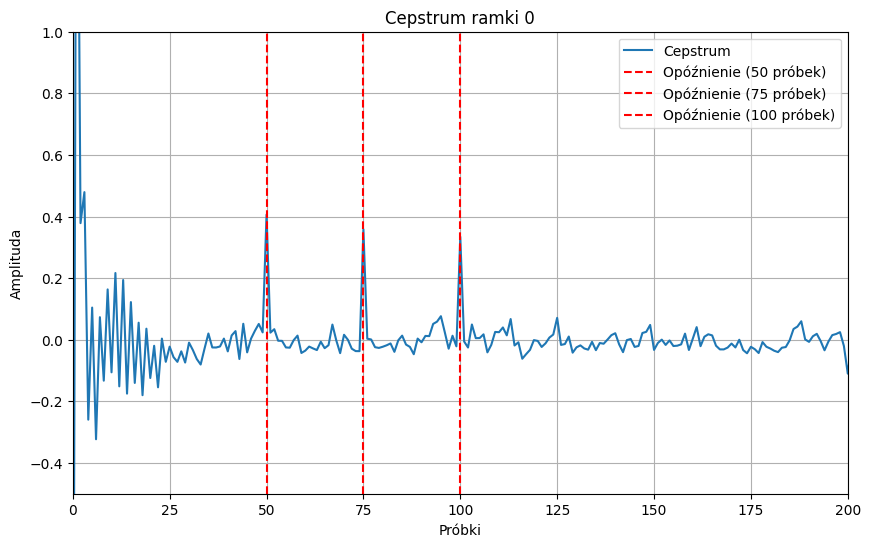

In [78]:
signal = output_with_echo

log_floor=0.00001

# Oblicz cepstrum
cepstrum = np.fft.ifft(np.log(np.abs(np.fft.fft(frame))**2 + log_floor)).real

detected_deltas = []
start = 26
for i, p in enumerate(cepstrum[start:200]):
    if p > 0.1:
        detected_deltas.append(i+start)

plt.figure(figsize=(10, 6))
plt.plot(cepstrum, label="Cepstrum")
for delta in detected_deltas:
    plt.axvline(x=delta, color='r', linestyle='--', label=f"Opóźnienie ({delta} próbek)")
plt.title(f"Cepstrum ramki {frame_index}")
plt.xlabel("Próbki")
plt.ylabel("Amplituda")
plt.xlim(0,200)
plt.ylim(-0.5, 1)
plt.legend()
plt.grid(True)
plt.show()